In [1]:
import gym
import numpy as np
import pandas as pd
import time
import os
import cv2
import copy
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import display, HTML
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
from gym.wrappers import GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
import gym_tetris
from nes_py.wrappers import JoypadSpace
from gym_tetris.actions import SIMPLE_MOVEMENT

In [2]:
from gym import Env
from gym.spaces import Discrete, Box

In [3]:
class tetrisGame(Env):
    def __init__(self):
        super().__init__()
        self.observation_space = Box(low=0, high=255, shape=(240, 120, 1), dtype=np.uint8)
        self.action_space = Discrete(4)
        
        self.game = gym_tetris.make('TetrisA-v3')
        self.game = JoypadSpace(self.game, [['A'], ['B'], ['right'], ['left']])
    def step(self, action):
        obs, reward, done, info = self.game.step(action)
        obs = self.preprocess(obs)
        d = info['statistics']
        curr_pieces = 0
        for i in d.values():
            curr_pieces += i
        prize = curr_pieces-self.n_pieces
        self.n_pieces = curr_pieces
        reward += prize
        
        if(done):
            reward -= 5
        
        return obs, reward, done, info
    def render(self, *args, **kwargs):
        return self.game.render(*args, **kwargs)
    def reset(self):
        obs = self.game.reset()
        obs = self.preprocess(obs)
        self.n_pieces = 0
        return obs
    def preprocess(self, observation):
        grey = cv2.cvtColor(observation, cv2.COLOR_BGR2GRAY)
        grey = np.reshape(grey, (240, 256, 1))
        croped = grey[:, 80:200, :]
        return croped
    def close(self):
        self.game.close()

In [4]:
CHECK_FREQ_NUMB = 10000
TOTAL_TIMESTEP_NUMB = 100000
LEARNING_RATE = 0.00001
N_STEPS = 1024
GAMMA = 0.9
BATCH_SIZE = 64
N_EPOCHS = 10
DOWN_SAMPLE_RATE = 2
SKIP_NUMB = 2
EPISODE_NUMBERS = 10

In [5]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [6]:
env = tetrisGame()
# env = Monitor(env, filename=LOG_DIR)
# env = DummyVecEnv([lambda: env])

In [ ]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if done:
                break
        return obs, reward, done, info
    
class Downsample(gym.ObservationWrapper):
    def __init__(self, env, ratio):
        """
        Downsample images by a factor of ratio
        """
        gym.ObservationWrapper.__init__(self, env)
        (oldh, oldw, oldc) = env.observation_space.shape
        newshape = (oldh//ratio, oldw//ratio, oldc)
        self.observation_space = gym.spaces.Box(low=0, high=255,
            shape=newshape, dtype=np.uint8)

    def observation(self, frame):
        height, width, _ = self.observation_space.shape
        frame = cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)
        if frame.ndim == 2:
            frame = frame[:,:,None]
        return frame
    
class Crop(gym.ObservationWrapper):
    def __init__(self, env):
        """
        Downsample images by a factor of ratio
        """
        gym.ObservationWrapper.__init__(self, env)
        (oldh, oldw, oldc) = env.observation_space.shape
        newshape = (oldh, 120, oldc)
        self.observation_space = gym.spaces.Box(low=0, high=255,
            shape=newshape, dtype=np.uint8)
    def observation(self, frame):
        frame = frame[:, 80:200, :]
        if frame.ndim == 2:
            frame = frame[:,:,None]
        return frame

In [ ]:
env = gym_tetris.make('TetrisA-v3')
env = JoypadSpace(env, [['A'], ['B'], ['right'], ['left']])
# env = Crop(env)
# env = SkipFrame(env, 2)
# env = Downsample(env, 2)

In [ ]:
SIMPLE_MOVEMENT

In [ ]:
state = env.reset()
done = False
info  = None
frames = []
while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    frames.append(copy.deepcopy(env.render(mode='rgb_array')))

In [ ]:
env = gym_tetris.make('TetrisA-v2')
env = JoypadSpace(env, [['A'], ['B'], ['right'], ['left']])
# env = SkipFrame(env, SKIP_NUMB)
env = Crop(env)
env = GrayScaleObservation(env, keep_dim=1)
# env = Downsample(env, 2)
env = DummyVecEnv([lambda: env])
# env = VecFrameStack(env, 4, channels_order='last')

In [ ]:
env.observation_space.shape

In [ ]:
env.action_space

In [7]:
state = env.reset()

In [ ]:
state.shape

In [57]:
state, reward, done, info = env.step(3)

In [58]:
print(reward)
print(info)

0.0
{'current_piece': 'Sh', 'number_of_lines': 0, 'score': 0, 'next_piece': 'Ih', 'statistics': {'T': 0, 'J': 0, 'Z': 0, 'O': 0, 'S': 1, 'L': 0, 'I': 0}, 'board_height': 0}


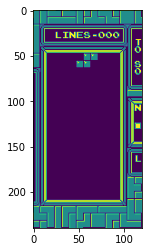

In [59]:
plt.imshow(state)

In [ ]:
model = PPO('CnnPolicy', env, verbose=0, tensorboard_log=LOG_DIR, learning_rate=LEARNING_RATE, n_steps=N_STEPS,
            batch_size=BATCH_SIZE, n_epochs=N_EPOCHS, gamma=GAMMA)

In [ ]:
# PPO??

In [ ]:
%%time
model.learn(total_timesteps=TOTAL_TIMESTEP_NUMB)

In [ ]:
model.save(path='./train/v2_200000')

In [ ]:
state = env.reset()
done = False
while not done:
    action, _  = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

In [ ]:
forvideo = PPO.load('./train/v2_200000')

In [ ]:
evaluate_policy(model, env, n_eval_episodes=EPISODE_NUMBERS, render=False)

In [ ]:
total_reward = [0] * EPISODE_NUMBERS
total_time = [0] * EPISODE_NUMBERS
best_reward = -100
frames_best = []

for i in range(EPISODE_NUMBERS):
    state = env.reset()  # reset for each new trial
    done = False
    total_reward[i] = 0
    total_time[i] = 0
    frames = []
    while not done:
        action, _ = forvideo.predict(state)
        state, reward, done, info = env.step(action)
        total_reward[i] += reward[0]
        total_time[i] += 1
#         frames.append(copy.deepcopy(env.render(mode='rgb_array')))

    if total_reward[i] > best_reward:
        best_reward = total_reward[i]
#         frames_best = copy.deepcopy(frames)

    print('test episode:', i, 'reward:', total_reward[i], 'time:', total_time[i])

print('average reward:', (sum(total_reward) / EPISODE_NUMBERS),
      'average time:', (sum(total_time) / EPISODE_NUMBERS),
      'best_reward:', best_reward)

In [ ]:
frames_new = np.array(frames_best)
matplotlib.rcParams['animation.embed_limit'] = 2**128
plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames_new[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames_new[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames_new), interval = 50)
display(HTML(ani.to_jshtml()))
plt.close()

In [9]:
state = env.reset()
done = False
score = 0   
while not done:
#     action, _ = forvideo.predict(state)
    state, reward, done, info = env.step(env.action_space.sample())
    print(reward)
    time.sleep(0.5)
    env.render()

1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


KeyboardInterrupt: 

In [ ]:
score

In [10]:
env.close()